Adding stored data to store the trades for calculation of results

In [ ]:
# Install all important libraries
!pip install yfinance
!pip install ta

In [ ]:
# NSE list Dont run
list = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS" , "BAJAJ-AUTO.NS", "GRASIM.NS","ONGC.NS", "TITAN.NS" , "SHREECEM.NS" ,\
        "NESTLEIND.NS", "GAIL.NS", "CIPLA.NS", "BHARTIARTL.NS" ,"NTPC.NS", "TATASTEEL.NS", "COALINDIA.NS", "BAJFINANCE.NS", "ICICIBANK.NS",\
       "BAJAJFINSV.NS", "WIPRO.NS", "HINDALCO.NS" , "HDFCLIFE.NS", "MARUTI.NS", "RELIANCE.NS", "TCS.NS", "LT.NS", "INDUSINDBK.NS", "ITC.NS" , "TECHM.NS"]

In [ ]:
# SGX list Dont run
list = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
        "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
        "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [ ]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


In [ ]:
# For event based backtesting, an imporatant concept is a bar.
# A bar is unit of data or information. A bar represents an event.
# Event based Backtesting will be based on new bars coming at not on full dataset.

# First we will build a commonclass,
# this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

In [ ]:
class Common_Class():

  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):

    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.quantity = 0 # quantities to buy/sell
    self.position = 0 # the trades in progress, long or short
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
    self.prepare_data() # prepares the data

  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data = bt_data.dropna()
    self.data = bt_data

  def close_graph(self):
    plt.figure(figsize=(15, 5))
    plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(self.symbol))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar):

    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date

    date = str(self.data.index[bar])[:10]
    price = self.data.Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):

    #Returns you the realised capital in your account at a given time period / bar

    date, price = self.return_date_price(bar)
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):

    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar

    date, price = self.return_date_price(bar)
    ub = self.quantity *price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):

    #Unrealised plus realised

    date, price = self.return_date_price(bar)
    tb = self.quantity *price + self.capital

    print("Date :{} | Total Balance: {:0.1f}".format(date,tb))

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])


  def performance(self):

    # Creating a temporary variable B to do all calculations
    # I could have also copied stored data, but I like single letter variables ( not recommended)

    B = self.stored_data
    B.index = range(B.shape[0]) # shape[0] to get the length of rows

    #Preparing metrics to calculate performance

    B['exit_date'] = B['date'].shift(-1) # The data was stored as a series of Buy / Sell or Sell / Buy in order
    B['exit_price'] = B['price'].shift(-1)
    B['capital_after_settlement'] = B['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the amount/capital you trade. So, its not like all returns are realised

    B['capital_regular_returns'] = (B['capital_after_settlement']/B['capital'] - 1)
    B['capital_log_returns'] = np.log(B['capital_after_settlement']/B['capital'])
    B["capital_returns_log_cum_sum"] = B["capital_log_returns"].cumsum()
    B.drop(B.index[B['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    B = B.dropna()

    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price','capital','capital_after_settlement', 'capital_regular_returns', 'capital_log_returns', 'capital_returns_log_cum_sum']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    #storing the results in Final_result data
    Final_result_data = B
    Final_result_data

    #Plot the equity curve
    plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns are {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation  is {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio is {:0.2f}".format(SR))

    #The strategy returns on investment in percent
    Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    Total_Log_ret
    Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, Regular_ROI))

    #print("The histogram of returns")
    #Final_result_data['capital_log_returns'].hist(bins= 40)


  def buy_order(self,bar,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity = self.quantity + quantity
    self.trades = self.trades + 1
    self.position = 1 #(To be stored in results. Will need for calculations)
    self.store_results(self.trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)


  def sell_order(self,bar,quantity=None, dollar=None ):
    date, price = self.return_date_price(bar)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity = self.quantity - quantity
    self.trades = self.trades + 1
    self.position = -1
    self.store_results(self.trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)


    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)

  def last_trade(self, bar):
    date, price = self.return_date_price(bar)
    last_quantity = self.quantity
    self.capital = self.capital + last_quantity * price
    self.quantity = 0 # as no more quantity now. all will be settled
    self.trades = self.trades +1
    if self.position == -1: # if closing out a short position
      last_quantity = - last_quantity # to keep a positve nymber in records
      self.position = 1 # to record we are buying to close out
    else:
      last_quantity =  last_quantity # to keep a positve nymber in records
      self.position = -1 # to record we are selling to close out
    #self.position = 0

    self.store_results(self.trades, date, self.position, price, self.symbol, last_quantity, self.quantity*price + self.capital)
    print("=" *50)
    print("--------------Final Balance-----------")
    self.total_balance(bar)
    print("=" *50)

    if self.verbose:
      print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,self.symbol, price, last_quantity * price))
      print("--------------Final Balance-----------")
      self.total_balance(bar)
      returns = (self.capital - self.initial_capital) /self.initial_capital *100
      print("------------------------------")
      print("The total capital at end of strategy: {:0.1f}".format(self.capital))
      print( "The strategy returns on investment are {:0.1f} %".format(returns))
      print( "Total trades by startegy are {:0.1f}".format(self.trades))


In [ ]:
'''
if __name__ == "__main__":
  A = Common_Class("AAPL", "2015-01-01", "2022-07-01","1d",10000, 0.0, True)
  A.close_graph()
'''

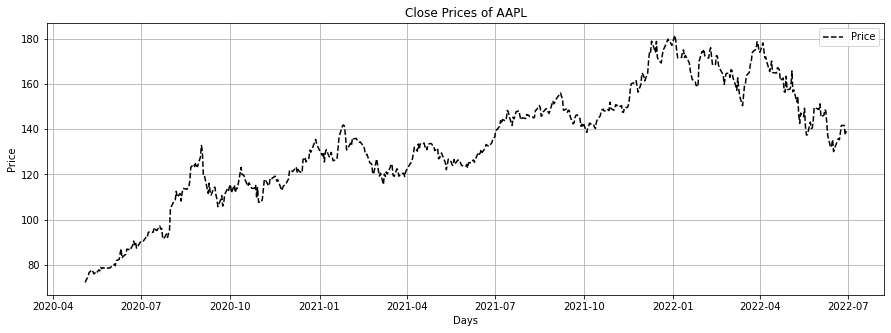

End of last bar
--------------Final Balance-----------
Date :2022-06-29 | Total Balance: 10840.9
   trade        date position       price symbol quantity       capital
0      1  2021-02-18        1  128.754456   AAPL       38  10000.000000
0      0  2021-02-19        1  128.913269   AAPL       38  10006.034912
0      0  2021-02-22        1  125.071777   AAPL       38   9860.058228
0      0  2021-02-23        1  124.932808   AAPL       38   9854.777390
0      0  2021-02-24        1  124.426575   AAPL       38   9835.540527
..   ...         ...      ...         ...    ...      ...           ...
0      0  2022-06-24       -1  141.660004   AAPL       34  10758.250916
0      0  2022-06-27       -1  141.660004   AAPL       34  10758.250916
0      0  2022-06-28       -1  137.440002   AAPL       34  10901.730957
0      0  2022-06-29       -1  139.229996   AAPL       34  10840.871185
0      4  2022-06-29        1  139.229996   AAPL       34  10840.871185

[346 rows x 7 columns]
The annual regu

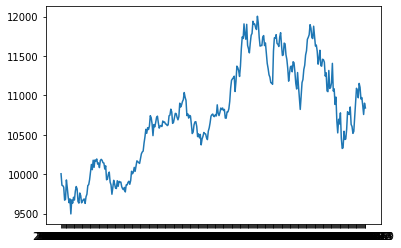

In [ ]:
class MA_Strategy(Common_Class):

  def go_long(self, bar, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position == -1:
      self.position = 0
      self.buy_order(bar, quantity = -self.quantity) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order (bar, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.buy_order(bar, dollar = dollar)


  def go_short(self, bar, quantity = None, dollar = None):
    if self.position == 1:
      self.position = 0
      self.sell_order(bar, quantity = self.quantity) #to clear previous long vposition
    if quantity:
      self.sell_order (bar, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.sell_order(bar, dollar = dollar)

  def run_strategy(self, STMA_window, LTMA_window): # add the parameters according to the strategy
    self.position = 0
    self.trades = 0
    self.capital = self.initial_capital

    indicator_1 = SMAIndicator(close = self.data ["Close_Price"], window = STMA_window, fillna= False)
    STMA = indicator_1.sma_indicator()

    indicator_2 = SMAIndicator(close = self.data ["Close_Price"], window = LTMA_window, fillna= False)
    LTMA = indicator_2.sma_indicator()

    self.data["STMA"] = STMA
    self.data["LTMA"] = LTMA

    for bar in range(LTMA_window, len(self.data)): # from the available data bar to the last data bar
      date, price = self.return_date_price(bar)

      if self.position in [0,-1]: # checking no position or short position
        if self.data["STMA"].iloc[bar]>self.data["LTMA"].iloc[bar]:
          self.go_long(bar, dollar=5000) # go with all money # Make sure to enter less than initila capital
          #print("--------")
          continue # as I am storing data for SR calculations. Dont wnat duplication. Continue to make sure 0 is added only on no conditions day

      if self.position in [0,1]: # checking no position or long position
        if self.data["STMA"].iloc[bar]<self.data["LTMA"].iloc[bar]:
          self.go_short(bar, dollar =5000) # go with all money
          #print("--------")
          continue

      #-----Storing all the values for calculating Sharpe-----
      store_quantity = abs(self.quantity) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
      self.store_results(0, date, self.position, price, self.symbol, store_quantity, self.quantity*price + self.capital)

    print("=" *50)
    print("End of last bar")
    print("=" *50)
    self.last_trade(bar)  # amke sure the crossover happens, give more time
    #print(self.stored_data.to_string())
    print(self.stored_data)


if __name__ == "__main__":
  A = MA_Strategy("AAPL", "2020-05-01", "2022-06-30","1d",10000, 0.0, False)
  A.close_graph()
  A.run_strategy(50,200)
  A.performance()
